In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import warnings
warnings.filterwarnings('ignore')


ДАТАСЕТ ICEWS

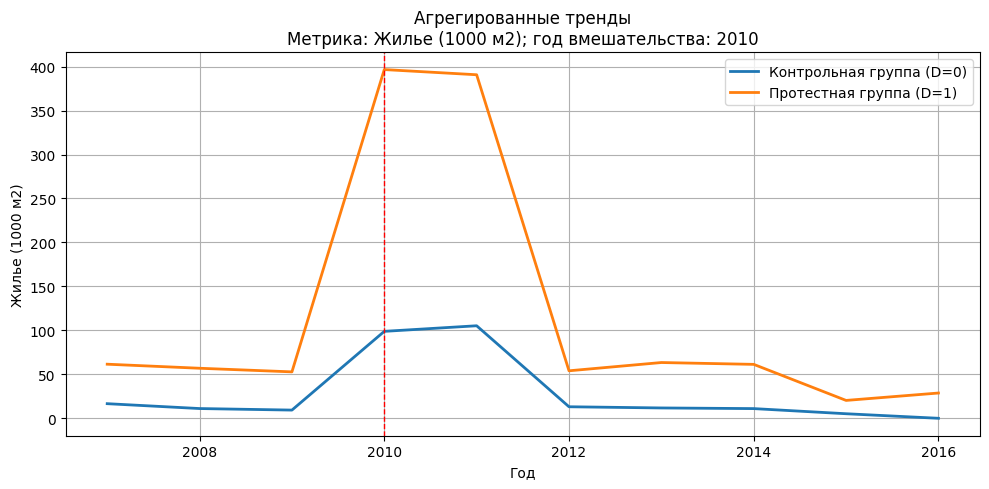

In [15]:
data = pd.read_csv('общие_данные_2010t.csv')
protest_events = ["Demonstrate or rally", "Criticize or denounce", "Defy norms, law"]

protest_municipalities = data[data['Event Text'].isin(protest_events)]['oktmo'].unique()
all_years_protest_municipalities = data[data['oktmo'].isin(protest_municipalities)]
noprotestALL = data[~data['oktmo'].isin(protest_municipalities)].reset_index(drop=True)

df_panel   = noprotestALL
df_treated = all_years_protest_municipalities
OUTCOME = 'Жилье (1000 м2)'    
TREAT_YEAR = 2010     
df_panel['group'] = 0   # Контрольные муниципалитеты
df_treated['group'] = 1   # Протестные муниципалитеты

# 3. Объединяем вертикально (concatenate)
df_panel = pd.concat([df_panel, df_treated], ignore_index=True)

df = df_panel[['year', 'municipality', 'oktmo',
                     'Жилье (1000 м2)', 'Дороги (%)', 'Канализация (1 м)', 'Водопровод (1 метр)',
                     'region_name', 'group']].drop_duplicates(subset=['year','oktmo', 'group'])


df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),           
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)

df = df[(df['year'] >= 2007) & (df['year'] <= 2022)]

control = df[df['group'] == 0]
treated = df[df['group'] == 1]


control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)


agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')
mask_until_2016 = agg['year'] <= 2016
agg = agg.loc[mask_until_2016].reset_index(drop=True)

plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





Статистика после обработки выбросов:
Контрольная группа: 164327 записей
Протестная группа: 5276 записей
Максимальное значение в контроле: 9860.00
Максимальное значение в протестах: 9200.00
Среднее значение в контроле: 59.71
Среднее значение в протестах: 364.34


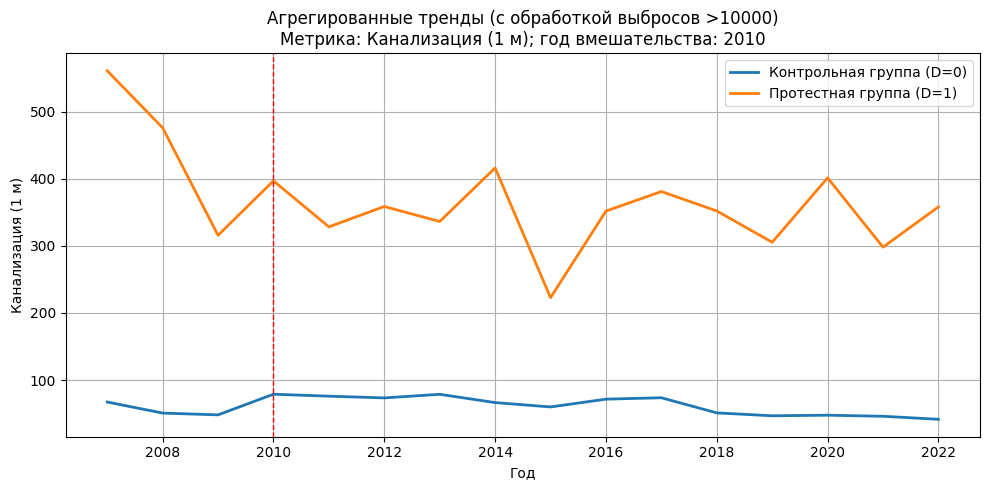

In [ ]:
data = pd.read_csv('общие_данные_2010t.csv')
protest_events = ["Demonstrate or rally", "Criticize or denounce", "Defy norms, law"]

protest_municipalities = data[data['Event Text'].isin(protest_events)]['oktmo'].unique()
all_years_protest_municipalities = data[data['oktmo'].isin(protest_municipalities)]
noprotestALL = data[~data['oktmo'].isin(protest_municipalities)].reset_index(drop=True)

df_panel   = noprotestALL
df_treated = all_years_protest_municipalities
OUTCOME = 'Канализация (1 м)'  # Изменено на канализацию
TREAT_YEAR = 2010     
df_panel['group'] = 0   # Контрольные муниципалитеты
df_treated['group'] = 1   # Протестные муниципалитеты

# 3. Объединяем вертикально (concatenate)
df_panel = pd.concat([df_panel, df_treated], ignore_index=True)

df = df_panel[['year', 'municipality', 'oktmo',
                     'Жилье (1000 м2)', 'Дороги (%)', 'Канализация (1 м)', 'Водопровод (1 метр)',
                     'region_name', 'group']].drop_duplicates(subset=['year','oktmo', 'group'])

# ЗАМЕНА ВЫБРОСОВ КАНАЛИЗАЦИИ > 10000 НА СРЕДНЕЕ ПО ГРУППЕ И ГОДУ
for group in [0, 1]:
    for year in df['year'].unique():
        # Фильтруем данные по группе и году
        mask = (df['group'] == group) & (df['year'] == year)
        
        # Получаем значения канализации без выбросов (< 10000)
        valid_values = df.loc[mask & (df['Канализация (1 м)'] < 10000), 'Канализация (1 м)']
        
        if len(valid_values) > 0:
            year_group_mean = valid_values.mean()
            
            # Заменяем выбросы на среднее по группе и году
            outlier_mask = mask & (df['Канализация (1 м)'] >= 10000)
            df.loc[outlier_mask, 'Канализация (1 м)'] = year_group_mean
            

df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),           
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)

df = df[(df['year'] >= 2007) & (df['year'] <= 2022)]

control = df[df['group'] == 0]
treated = df[df['group'] == 1]

# Дополнительная статистика после замены выбросов
print("\nСтатистика после обработки выбросов:")
print(f"Контрольная группа: {len(control)} записей")
print(f"Протестная группа: {len(treated)} записей")
print(f"Максимальное значение в контроле: {control['outcome'].max():.2f}")
print(f"Максимальное значение в протестах: {treated['outcome'].max():.2f}")
print(f"Среднее значение в контроле: {control['outcome'].mean():.2f}")
print(f"Среднее значение в протестах: {treated['outcome'].mean():.2f}")

control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)

agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')

plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды (с обработкой выбросов >10000)\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

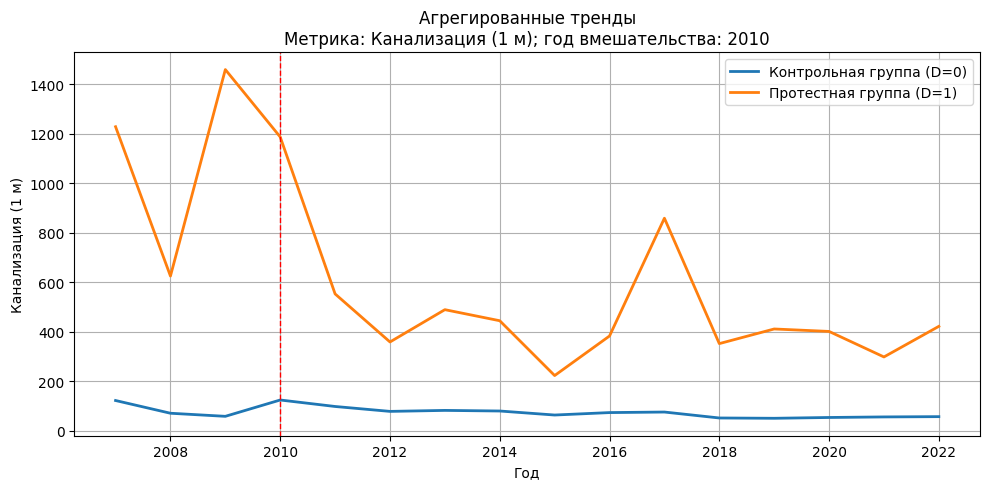

In [9]:
data = pd.read_csv('общие_данные_2010t.csv')
protest_events = ["Demonstrate or rally", "Criticize or denounce", "Defy norms, law"]

protest_municipalities = data[data['Event Text'].isin(protest_events)]['oktmo'].unique()
all_years_protest_municipalities = data[data['oktmo'].isin(protest_municipalities)]
noprotestALL = data[~data['oktmo'].isin(protest_municipalities)].reset_index(drop=True)

df_panel   = noprotestALL
df_treated = all_years_protest_municipalities
OUTCOME = 'Канализация (1 м)'    
TREAT_YEAR = 2010     
df_panel['group'] = 0   # Контрольные муниципалитеты
df_treated['group'] = 1   # Протестные муниципалитеты

# 3. Объединяем вертикально (concatenate)
df_panel = pd.concat([df_panel, df_treated], ignore_index=True)

df = df_panel[['year', 'municipality', 'oktmo',
                     'Жилье (1000 м2)', 'Дороги (%)', 'Канализация (1 м)', 'Водопровод (1 метр)',
                     'region_name', 'group']].drop_duplicates(subset=['year','oktmo', 'group'])


df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),           
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)

df = df[(df['year'] >= 2007) & (df['year'] <= 2022)]

control = df[df['group'] == 0]
treated = df[df['group'] == 1]


control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)


agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')


plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





Статистика после обработки выбросов:
Контрольная группа: 164327 записей
Протестная группа: 5276 записей
Максимальное значение в контроле: 29968.00
Максимальное значение в протестах: 29800.00


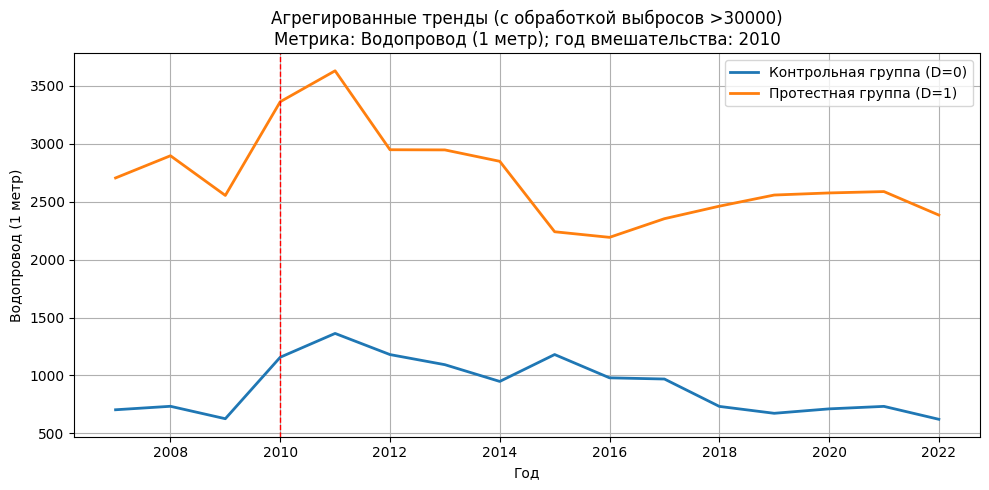

In [ ]:
data = pd.read_csv('общие_данные_2010t.csv')
protest_events = ["Demonstrate or rally", "Criticize or denounce", "Defy norms, law"]

protest_municipalities = data[data['Event Text'].isin(protest_events)]['oktmo'].unique()
all_years_protest_municipalities = data[data['oktmo'].isin(protest_municipalities)]
noprotestALL = data[~data['oktmo'].isin(protest_municipalities)].reset_index(drop=True)

df_panel   = noprotestALL
df_treated = all_years_protest_municipalities
OUTCOME = 'Водопровод (1 метр)'    
TREAT_YEAR = 2010     
df_panel['group'] = 0   # Контрольные муниципалитеты
df_treated['group'] = 1   # Протестные муниципалитеты

# 3. Объединяем вертикально (concatenate)
df_panel = pd.concat([df_panel, df_treated], ignore_index=True)

df = df_panel[['year', 'municipality', 'oktmo',
                     'Жилье (1000 м2)', 'Дороги (%)', 'Канализация (1 м)', 'Водопровод (1 метр)',
                     'region_name', 'group']].drop_duplicates(subset=['year','oktmo', 'group'])

# ЗАМЕНА ВЫБРОСОВ ВОДОПРОВОДА > 30000 НА СРЕДНЕЕ ПО ГРУППЕ И ГОДУ
for group in [0, 1]:
    for year in df['year'].unique():
        # Фильтруем данные по группе и году
        mask = (df['group'] == group) & (df['year'] == year)
        
        # Получаем значения водопровода без выбросов (< 30000)
        valid_values = df.loc[mask & (df['Водопровод (1 метр)'] < 30000), 'Водопровод (1 метр)']
        
        if len(valid_values) > 0:
            year_group_mean = valid_values.mean()
            
            # Заменяем выбросы на среднее по группе и году
            outlier_mask = mask & (df['Водопровод (1 метр)'] >= 30000)
            df.loc[outlier_mask, 'Водопровод (1 метр)'] = year_group_mean
            
            # print(f"Группа {group}, год {year}: Заменено {outlier_mask.sum()} выбросов на {year_group_mean:.2f}")

df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),           
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)

df = df[(df['year'] >= 2007) & (df['year'] <= 2022)]

control = df[df['group'] == 0]
treated = df[df['group'] == 1]



control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)

agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')

plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды (с обработкой выбросов >30000)\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

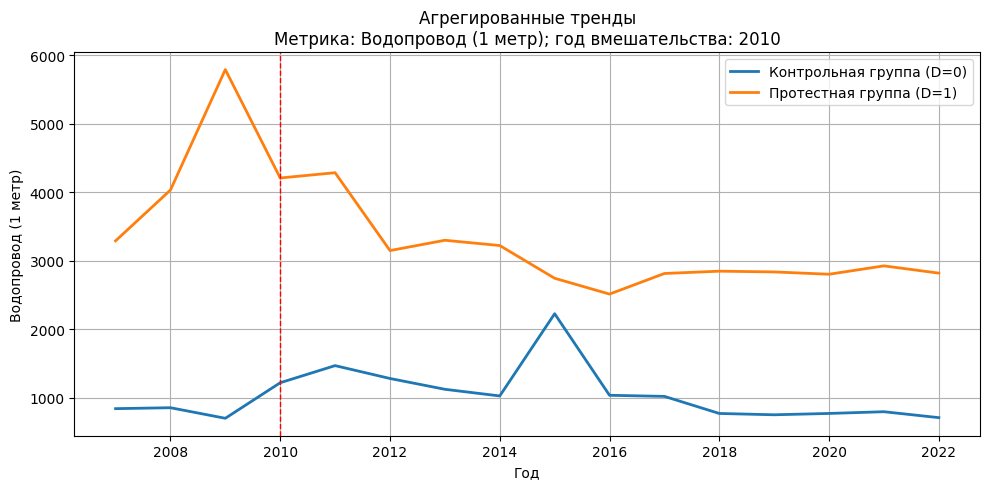

In [4]:
data = pd.read_csv('общие_данные_2010t.csv')
protest_events = ["Demonstrate or rally", "Criticize or denounce", "Defy norms, law"]

protest_municipalities = data[data['Event Text'].isin(protest_events)]['oktmo'].unique()
all_years_protest_municipalities = data[data['oktmo'].isin(protest_municipalities)]
noprotestALL = data[~data['oktmo'].isin(protest_municipalities)].reset_index(drop=True)

df_panel   = noprotestALL
df_treated = all_years_protest_municipalities
OUTCOME = 'Водопровод (1 метр)'    
TREAT_YEAR = 2010     
df_panel['group'] = 0   # Контрольные муниципалитеты
df_treated['group'] = 1   # Протестные муниципалитеты

# 3. Объединяем вертикально (concatenate)
df_panel = pd.concat([df_panel, df_treated], ignore_index=True)

df = df_panel[['year', 'municipality', 'oktmo',
                     'Жилье (1000 м2)', 'Дороги (%)', 'Канализация (1 м)', 'Водопровод (1 метр)',
                     'region_name', 'group']].drop_duplicates(subset=['year','oktmo', 'group'])


df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),           
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)

df = df[(df['year'] >= 2007) & (df['year'] <= 2022)]

control = df[df['group'] == 0]
treated = df[df['group'] == 1]


control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)


agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')


plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




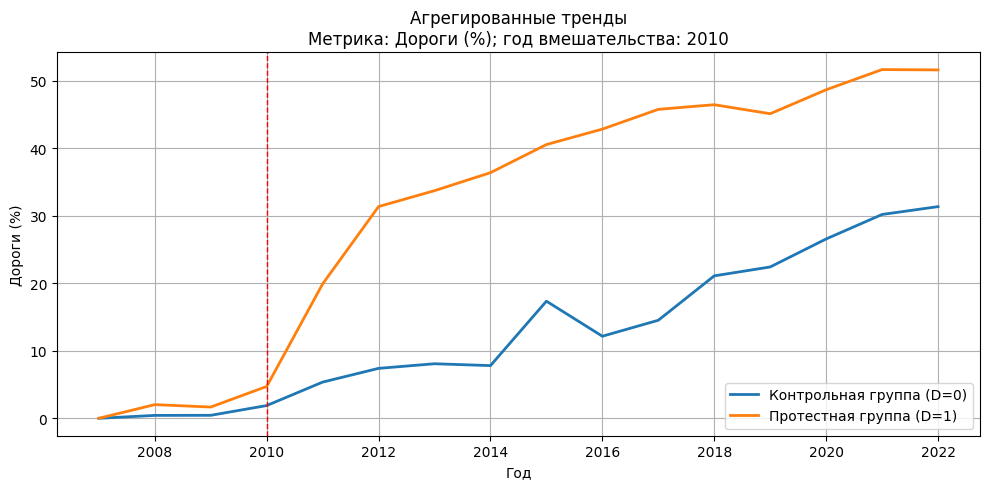

In [5]:


data = pd.read_csv('общие_данные_2010t.csv')
protest_events = ["Demonstrate or rally", "Criticize or denounce", "Defy norms, law"]

protest_municipalities = data[data['Event Text'].isin(protest_events)]['oktmo'].unique()
all_years_protest_municipalities = data[data['oktmo'].isin(protest_municipalities)]
noprotestALL = data[~data['oktmo'].isin(protest_municipalities)].reset_index(drop=True)

df_panel   = noprotestALL
df_treated = all_years_protest_municipalities
OUTCOME = 'Дороги (%)'    
TREAT_YEAR = 2010     
df_panel['group'] = 0   # Контрольные муниципалитеты
df_treated['group'] = 1   # Протестные муниципалитеты

# 3. Объединяем вертикально (concatenate)
df_panel = pd.concat([df_panel, df_treated], ignore_index=True)

df = df_panel[['year', 'municipality', 'oktmo',
                     'Жилье (1000 м2)', 'Дороги (%)', 'Канализация (1 м)', 'Водопровод (1 метр)',
                     'region_name', 'group']].drop_duplicates(subset=['year','oktmo', 'group'])


df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),           
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)

df = df[(df['year'] >= 2007) & (df['year'] <= 2022)]

control = df[df['group'] == 0]
treated = df[df['group'] == 1]


control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)


agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')


plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




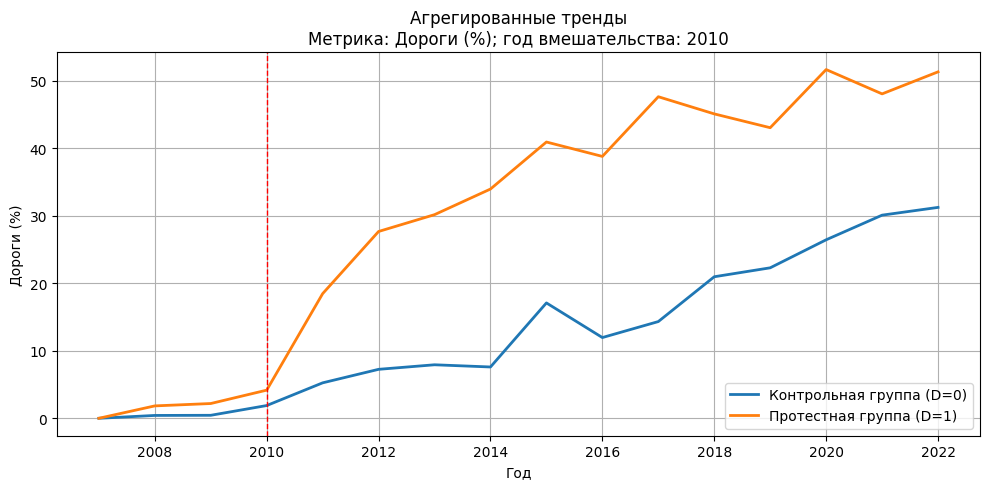

In [ ]:
df_panel   = pd.read_csv('единицы_без_протестов_2010t.csv')
df_treated = pd.read_csv('протесты_2010t.csv')

OUTCOME = 'Дороги (%)'    
TREAT_YEAR = 2010     
df_panel['group'] = 0   # Контрольные муниципалитеты
df_treated['group'] = 1   # Протестные муниципалитеты

# 3. Объединяем вертикально (concatenate)
df_panel = pd.concat([df_panel, df_treated], ignore_index=True)

df = df_panel[['year', 'municipality', 'oktmo',
                     'Жилье (1000 м2)', 'Дороги (%)', 'Канализация (1 м)', 'Водопровод (1 метр)',
                     'region_name', 'group']].drop_duplicates(subset=['year','oktmo', 'group'])


df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),           
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)

df = df[(df['year'] >= 2007) & (df['year'] <= 2022)]

control = df[df['group'] == 0]
treated = df[df['group'] == 1]


control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)


agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')


plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Те же результаты, но с исключением значений муниципалитетов, где все показатели инфраструктуры равны 0 (как недостоверные)

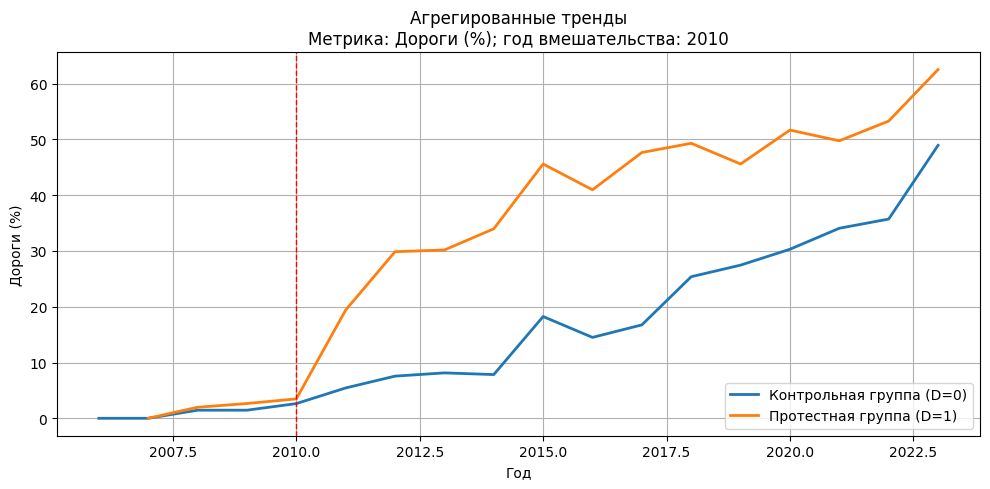

In [ ]:
CSV_PATH = 'panel_all.csv'      

OUTCOME = 'Дороги (%)'               
TREAT_YEAR = 2010                  
OUTPUT_DIR = Path('did_output')    


df = pd.read_csv(CSV_PATH)
df['year'] = df['year'].astype(float).round().astype(int)



df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),          
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)


control = df[df['group'] == 0]
treated = df[df['group'] == 1]


control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)


agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')


plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ДАТАСЕТ ЛАНКИНОЙ

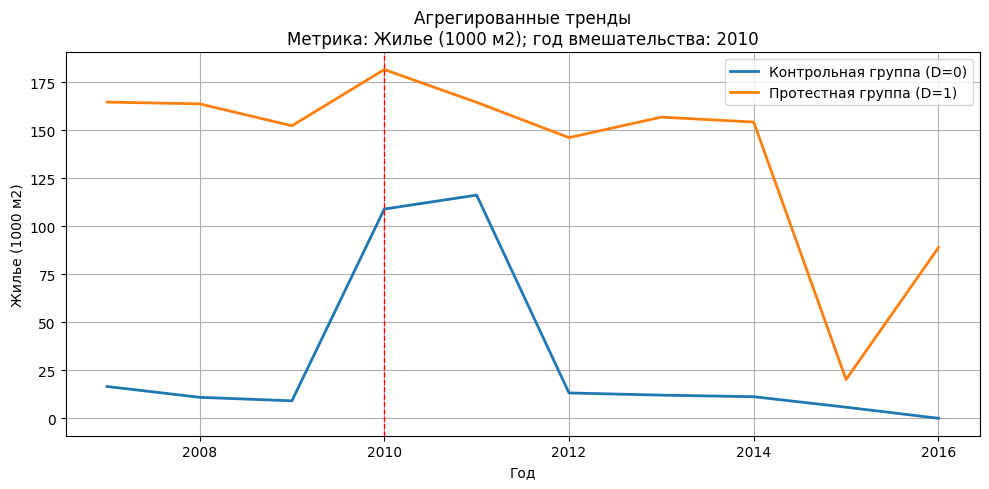

In [ ]:


data = pd.read_csv('общие_данные_2010t4.csv')
# protest_events = ["Demonstrate or rally", "Criticize or denounce", "Defy norms, law"]
protest_events = [1]
protest_municipalities = data[data['Event text'].isin(protest_events)]['oktmo'].unique()
all_years_protest_municipalities = data[data['oktmo'].isin(protest_municipalities)]
noprotestALL = data[~data['oktmo'].isin(protest_municipalities)].reset_index(drop=True)

df_panel   = noprotestALL
df_treated = all_years_protest_municipalities
OUTCOME = 'Жилье (1000 м2)'  
TREAT_YEAR = 2010     
df_panel['group'] = 0   # Контрольные муниципалитеты
df_treated['group'] = 1   # Протестные муниципалитеты

# 3. Объединяем вертикально (concatenate)
df_panel = pd.concat([df_panel, df_treated], ignore_index=True)

df = df_panel[['year', 'municipality', 'oktmo',
                     'Жилье (1000 м2)', 'Дороги (%)', 'Канализация (1 м)', 'Водопровод (1 метр)',
                     'region_name', 'group']].drop_duplicates(subset=['year','oktmo', 'group'])


df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),           
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)

df = df[(df['year'] >= 2007) & (df['year'] <= 2022)]

control = df[df['group'] == 0]
treated = df[df['group'] == 1]


control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)


agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')
mask_until_2016 = agg['year'] <= 2016
agg = agg.loc[mask_until_2016].reset_index(drop=True)

plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




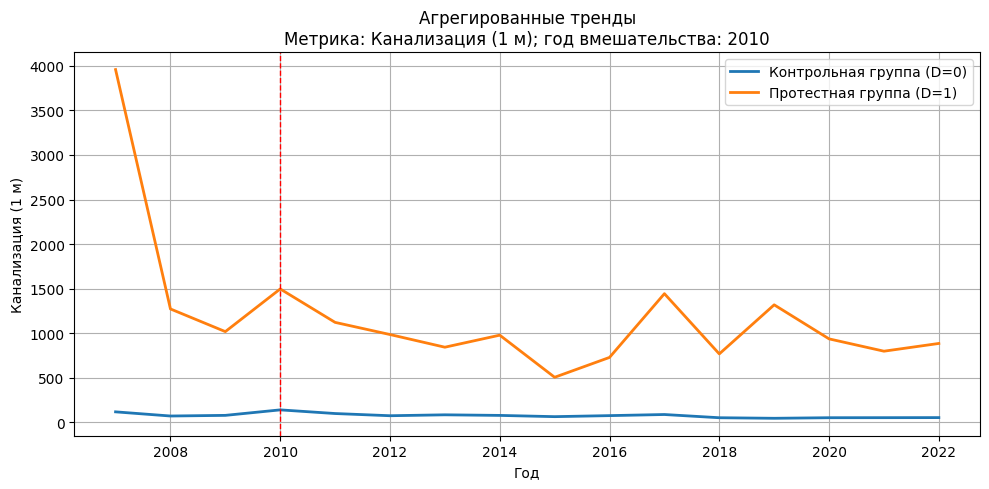

In [13]:


data = pd.read_csv('общие_данные_2010t4.csv')
# protest_events = ["Demonstrate or rally", "Criticize or denounce", "Defy norms, law"]
protest_events = [1]
protest_municipalities = data[data['Event text'].isin(protest_events)]['oktmo'].unique()
all_years_protest_municipalities = data[data['oktmo'].isin(protest_municipalities)]
noprotestALL = data[~data['oktmo'].isin(protest_municipalities)].reset_index(drop=True)

df_panel   = noprotestALL
df_treated = all_years_protest_municipalities
OUTCOME = 'Канализация (1 м)'  
TREAT_YEAR = 2010     
df_panel['group'] = 0   # Контрольные муниципалитеты
df_treated['group'] = 1   # Протестные муниципалитеты

# 3. Объединяем вертикально (concatenate)
df_panel = pd.concat([df_panel, df_treated], ignore_index=True)

df = df_panel[['year', 'municipality', 'oktmo',
                     'Жилье (1000 м2)', 'Дороги (%)', 'Канализация (1 м)', 'Водопровод (1 метр)',
                     'region_name', 'group']].drop_duplicates(subset=['year','oktmo', 'group'])


df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),           
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)

df = df[(df['year'] >= 2007) & (df['year'] <= 2022)]

control = df[df['group'] == 0]
treated = df[df['group'] == 1]


control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)


agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')


plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




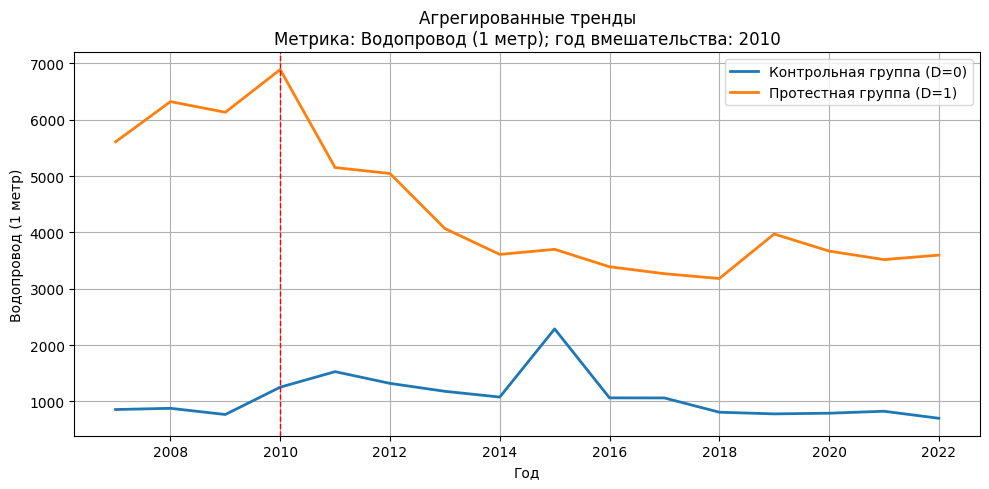

In [12]:


data = pd.read_csv('общие_данные_2010t4.csv')
# protest_events = ["Demonstrate or rally", "Criticize or denounce", "Defy norms, law"]
protest_events = [1]
protest_municipalities = data[data['Event text'].isin(protest_events)]['oktmo'].unique()
all_years_protest_municipalities = data[data['oktmo'].isin(protest_municipalities)]
noprotestALL = data[~data['oktmo'].isin(protest_municipalities)].reset_index(drop=True)

df_panel   = noprotestALL
df_treated = all_years_protest_municipalities
OUTCOME = 'Водопровод (1 метр)'  
TREAT_YEAR = 2010     
df_panel['group'] = 0   # Контрольные муниципалитеты
df_treated['group'] = 1   # Протестные муниципалитеты

# 3. Объединяем вертикально (concatenate)
df_panel = pd.concat([df_panel, df_treated], ignore_index=True)

df = df_panel[['year', 'municipality', 'oktmo',
                     'Жилье (1000 м2)', 'Дороги (%)', 'Канализация (1 м)', 'Водопровод (1 метр)',
                     'region_name', 'group']].drop_duplicates(subset=['year','oktmo', 'group'])


df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),           
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)

df = df[(df['year'] >= 2007) & (df['year'] <= 2022)]

control = df[df['group'] == 0]
treated = df[df['group'] == 1]


control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)


agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')


plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




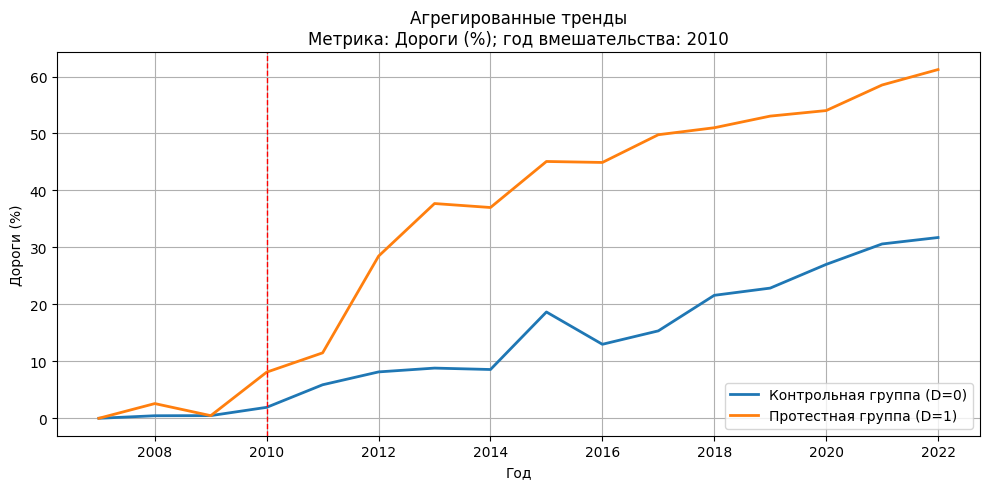

In [8]:


data = pd.read_csv('общие_данные_2010t4.csv')
# protest_events = ["Demonstrate or rally", "Criticize or denounce", "Defy norms, law"]
protest_events = [1]
protest_municipalities = data[data['Event text'].isin(protest_events)]['oktmo'].unique()
all_years_protest_municipalities = data[data['oktmo'].isin(protest_municipalities)]
noprotestALL = data[~data['oktmo'].isin(protest_municipalities)].reset_index(drop=True)

df_panel   = noprotestALL
df_treated = all_years_protest_municipalities
OUTCOME = 'Дороги (%)'    
TREAT_YEAR = 2010     
df_panel['group'] = 0   # Контрольные муниципалитеты
df_treated['group'] = 1   # Протестные муниципалитеты

# 3. Объединяем вертикально (concatenate)
df_panel = pd.concat([df_panel, df_treated], ignore_index=True)

df = df_panel[['year', 'municipality', 'oktmo',
                     'Жилье (1000 м2)', 'Дороги (%)', 'Канализация (1 м)', 'Водопровод (1 метр)',
                     'region_name', 'group']].drop_duplicates(subset=['year','oktmo', 'group'])


df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),           
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)

df = df[(df['year'] >= 2007) & (df['year'] <= 2022)]

control = df[df['group'] == 0]
treated = df[df['group'] == 1]


control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)


agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')


plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




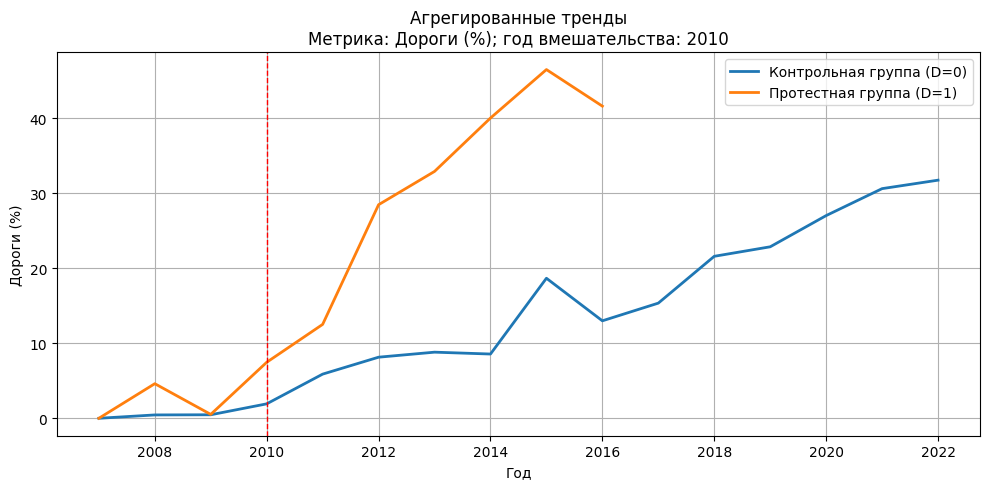

In [9]:
df_panel   = pd.read_csv('единицы_без_протестов_2010t4.csv')
df_treated = pd.read_csv('протесты_2010t4.csv')

OUTCOME = 'Дороги (%)'    
TREAT_YEAR = 2010     
df_panel['group'] = 0   # Контрольные муниципалитеты
df_treated['group'] = 1   # Протестные муниципалитеты

# 3. Объединяем вертикально (concatenate)
df_panel = pd.concat([df_panel, df_treated], ignore_index=True)

df = df_panel[['year', 'municipality', 'oktmo',
                     'Жилье (1000 м2)', 'Дороги (%)', 'Канализация (1 м)', 'Водопровод (1 метр)',
                     'region_name', 'group']].drop_duplicates(subset=['year','oktmo', 'group'])


df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),           
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)

df = df[(df['year'] >= 2007) & (df['year'] <= 2022)]

control = df[df['group'] == 0]
treated = df[df['group'] == 1]


control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)


agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')


plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Те же результаты, но с исключением значений муниципалитетов, где все показатели инфраструктуры равны 0 (как недостоверные)

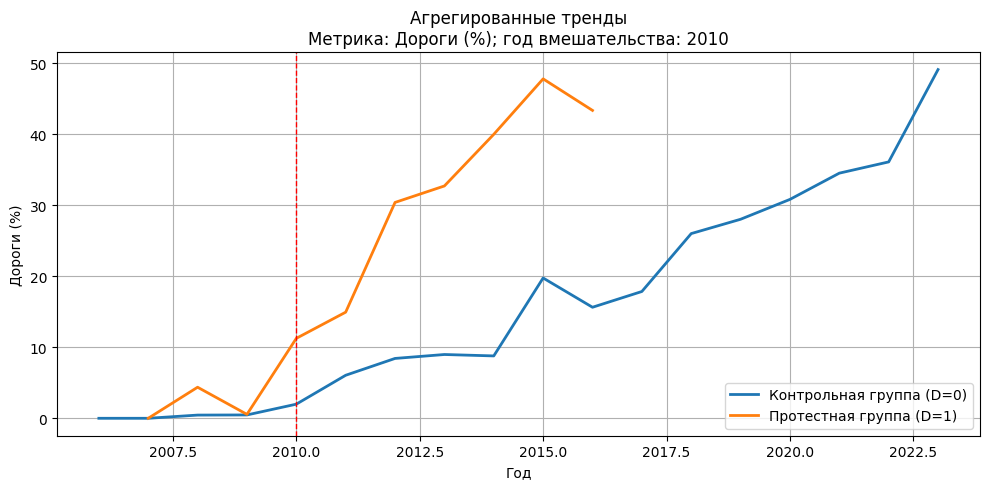

In [5]:

CSV_PATH = 'panel_all3.csv'         
OUTCOME = 'Дороги (%)'              
TREAT_YEAR = 2010                   
OUTPUT_DIR = Path('did_output')      


df = pd.read_csv(CSV_PATH)
df['year'] = df['year'].astype(float).round().astype(int)

df = (
    df.groupby(['oktmo', 'year'], dropna=False)
      .agg(
          group=('group', 'max'),           
          outcome=(OUTCOME, 'mean')         
      )
      .reset_index()
)


control = df[df['group'] == 0]
treated = df[df['group'] == 1]


control_agg = (
    control.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_control'})
)

treated_agg = (
    treated.groupby('year', dropna=False)['outcome']
    .mean()
    .reset_index()
    .rename(columns={'outcome': 'mean_treated'})
)


agg = pd.merge(control_agg, treated_agg, on='year', how='outer').sort_values('year')


plt.figure(figsize=(10, 5))
plt.plot(agg['year'], agg['mean_control'], label='Контрольная группа (D=0)', lw=2)
plt.plot(agg['year'], agg['mean_treated'], label='Протестная группа (D=1)', lw=2)

plt.axvline(TREAT_YEAR, linestyle='--', linewidth=1, color='red')
plt.title(f'Агрегированные тренды\nМетрика: {OUTCOME}; год вмешательства: {TREAT_YEAR}')
plt.xlabel('Год')
plt.ylabel(OUTCOME)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
